<h1><center> Analyzing Airbnb listings</center></h1>
<h3> <center>Finding the busiest hosts and hotspot locations on Airbnb</center></h3>
The aim of this project is to exlpore the Airbnb data to analyze and answer the following questions - 

       Which hosts are the busiest and why?
       What areas have more traffic than others and why is that the case?
       Are there any relationships between prices and number of reviews for a given listing?
       
Airbnb is an online market place for arranging or offering primarily home stays, lodging or tourism experiences. People can become hosts and list their property(s) on Airbnb. Since 2008, guests and hosts have used Airbnb to expand on traveling possibilities and present more unique, personalized way of experiencing the world. This dataset describes the listing activity and metrics in NYC, NY for 2019.
       
The dataset can be found at this <a href="https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data">Link</a>
<br>
Descirbing a few columns :-

       name - name of the listing
       calculated_host_listings_count - amount of listings per host
       availability_365 - Number of days when listing is available for booking
       neighbourhood_group - Location
       last_review - date of last review
       reviews_per_month - number of reviews per month on average
       
The data for each listing seems limited. The columns individually are inconclusive to answer the questions directly. Hence Proxies have to be assumed in order to fulfill the purpose.

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Importing the dataset

In [2]:
df = pd.read_csv('AB_NYC_2019.csv')
df.head(5)

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [3]:
df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [4]:
df[df.last_review.isna() & df.reviews_per_month.isna()].number_of_reviews.value_counts()

0    10052
Name: number_of_reviews, dtype: int64

The null values in the `last_review` and `reviews_per_month` columns, conclude that these values are Null when `number_of_reviews` is 0. Which in simple terms means, that if the `number_of_reviews` is 0, there can be no `last_review` date nor `reviews_per_month` metric.

In [5]:
df[['last_review','reviews_per_month']] = df[['last_review','reviews_per_month']].fillna(0)

The values in the `host_name` column are unique, this makes it difficult to impute and hence ignoring these rows would be a better option. In general sense there will not be signficant loss in data. Similarly the `names` column having Null values is also ignored.

In [21]:
df.host_name.value_counts(dropna=False)

Michael         417
David           403
Sonder (NYC)    327
John            294
Alex            279
               ... 
DyAnna            1
Keyur             1
Ossama            1
Jonatan           1
Kwankaew          1
Name: host_name, Length: 11453, dtype: int64

In [6]:
df.host_id.value_counts(dropna=False)

219517861    327
107434423    232
30283594     121
137358866    103
12243051      96
            ... 
1641589        1
4070519        1
208106618      1
235939247      1
1288080        1
Name: host_id, Length: 37457, dtype: int64

The two frequency tables from above conclude that:-
 * Alot of Hosts have multiple properites listed on the website.
 * The names of the hosts do repeat and hence, host_id is a better way to represent a host and all his/her listings rather than the host_name.

Now to explore the first question - Which hosts are the busiest and why?<br>

The first step is to define what the term 'busiest' means in the context of the data. The data, to start with, is incoclusive to directly define 'busiest'. Hence for the purpose of the analysis, a proxy has been assumed which relates to 'busiest'. The dataset has a few columns that can be leveraged to define 'busiest' in this context - `reviews_per_month`, `availability_365` and `minimum_nights`.

The `availability_365` represents the number of days in a year, the location is open for bookings. All rows having a 0 means this place is temporarily shut down/not accepting bookings currently. The focus of the analysis is to find the hosts that are the 'busiest' it goes without saying that hosts having properties not accepting bookings are irrelevant to the analysis.

This means the population for the analysis is the set of all listings on AirBnB website. The sample chosen for the analysis is a set of those listings who are currently accepting bookings.

In [7]:
df = df[df.availability_365 > 0]

In [8]:
df.minimum_nights.describe()

count    31362.000000
mean         8.338658
std         23.836703
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

The `minimum_nights` column seems to have outliers with values exceeding `availability_365` or even out of the bounds of 365. 
For ease of analysis the following conclusions have been made:
* The minimum_nights have to be within 365 days
* The minimum_nights cannot exceed availabilty_365
By these conclusions, only an year or one period of business (depending on `availability_365`) is taken into account when analyzing the data for busiest hosts.

In [9]:
df = df[df.minimum_nights <= df.availability_365]

A metric is a system of measurement in this case 'busiest' which gives a relative comparision between the hosts. The metric defined below is a proxy to estimate the busyness of a host. The metric here using the fore-mentioned columns estimates the percentage of occupancy the property has seen in one period of business. The metric mean across various properties for a host gives the average occupancy rate/percentage the host. The higher the percentage, the busier a host is said to be.<br>
The 3 columns afore-mentioend are taken into consideration for calculating this metric. <br>

Firstly, the metric needs the available months (one period of business) the host is open for business/accepting bookings :-

   <h6>available months =  <B><sup>available days</sup> / <sub>(365/12) </sub></B></h6> 
    
For the given months the property is open for business, next is to estimate the maximum possible bookings a property can have through the available days, here the assumption is that, every customer stays exactly equal to minimum nights required by the listing :-

   <h6>total possible bookings = <B><sup>available days</sup> / <sub>minimum nights</sub></B></h6>

The next step is to estimate the actual number of bookings that occured in the year. The assumption made here is that the number of reviews recieved per month is analogous to that many customers on average booked/stayed in this property. Hence we will estimate bookings as :-

   <h6>estimated bookings = <b>reviews per month x available months</b></h6>
   
Using all the above calculations, the percentage of occupancy throughout the year is gives as :-

   <h6>occupancy % = <b><sup>estimated bookings</sup> / <sub>total possible bookings</sub> x 100</b></h6><br>
   
   
POINT TO NOTE - According to the assumptions and calculations done above to calculate the metric, a property  with 1 customer over the entire period of business as the property's total possible booking records a 100% when the estimated bookings is also 1. In simpler terms, if the expected booking count is calculated to be 1 and the property hosts 1 customer, then the property is said to be 100% busy.

In [10]:
avg_month_length = 365/12
df['availability_months'] = df.availability_365 / avg_month_length

df['max_possible_bookings'] = df.availability_365 / df.minimum_nights
df['booking_estimate'] = df.reviews_per_month * df.availability_months

After all afore-mentioned calculations, there are outliers in the metric, where the estimated booking is more than the total possible bookings. <br>
This is because of the fact that the column `reviews_per_month` is an average value and can show a very optimistic side for a few rows. These rows become irrelevant to the data.<br>

NOTE: Since the metric is a proxy to define 'busiest', its not exactly perfect and the metric doesnot give the exact occupancy percentage the property bore, rather just a relativistic view. Hence for these reasons, tolerance is shown for losing data.

In [13]:
df = df[df.booking_estimate <= df.max_possible_bookings]

Calculating the occupancy % as explained above.

In [14]:
df['occupancy_percentage'] = (df.booking_estimate / df.max_possible_bookings) * 100
df.head(5)

id                                       name  host_id    host_name  \
0  2539         Clean & quiet apt home by the park     2787         John   
1  2595                      Skylit Midtown Castle     2845     Jennifer   
2  3647        THE VILLAGE OF HARLEM....NEW YORK !     4632    Elisabeth   
3  3831            Cozy Entire Floor of Brownstone     4869  LisaRoxanne   
5  5099  Large Cozy 1 BR Apartment In Midtown East     7322        Chris   

  neighbourhood_group neighbourhood  latitude  longitude        room_type  \
0            Brooklyn    Kensington  40.64749  -73.97237     Private room   
1           Manhattan       Midtown  40.75362  -73.98377  Entire home/apt   
2           Manhattan        Harlem  40.80902  -73.94190     Private room   
3            Brooklyn  Clinton Hill  40.68514  -73.95976  Entire home/apt   
5           Manhattan   Murray Hill  40.74767  -73.97500  Entire home/apt   

   price  minimum_nights  number_of_reviews last_review  reviews_per_month  \
0    149               1                  9  2018-10-19               0.21   
1    225               1                 45  2019-05-21               0.38   
2    150               3                  0           0               0.00   
3     89               1                270  2019-07-05               4.64   
5    200               3                 74  2019-06-22               0.59   

   calculated_host_listings_count  availability_365  availability_months  \
0                               6               365            12.000000   
1                               2               355            11.671233   
2                               1               365            12.000000   
3                               1               194             6.378082   
5                               1               129             4.241096   

   max_possible_bookings  booking_estimate  occupancy_percentage  
0             365.000000          2.520000              0.690411  
1             355.000000          4.435068              1.249315  
2             121.666667          0.000000              0.000000  
3             194.000000         29.594301             15.254795  
5              43.000000          2.502247              5.819178

The `host_name` column as discussed before contains repeating names, the `calculated_host_listings_count` gives us a fair idea of how many properties in total a host owns. The use of `host_id` as primary for the `groupby` function is the only way. Followed by `host_name` for `groupby` since the names of the hosts is important in the analysis.<br>
The `mean` is used as the aggregating function for the `occupancy_percentage` and `price` columns to get a fair idea about the general trend for each host, whereas for the `neighbourhood_group` and `neighbourhood` columns, the mode indicating the location where majority of host's properties reside, is used.
The mode is chosen for the location columns because, the mode i.e. most frequent location for the property means the majority of contributions to the `occupancy_percentage` come from here.

In [15]:
grouped = df[[
    'host_id',
    'host_name',
    'occupancy_percentage',
    'price'
    ,'neighbourhood_group',
    'neighbourhood'
]].groupby(['host_id','host_name'])

df_occupancy = grouped.agg({
    'occupancy_percentage':'mean',
    'price':'mean',
    'neighbourhood_group':pd.Series.mode,
    'neighbourhood':pd.Series.mode
}).reset_index()

The grouped table now contains the average occupany percentage for every host. Sorting the table to obtain the top 50 busiest hosts for Airbnb.

In [16]:
Top_50 = df_occupancy.sort_values('occupancy_percentage',ascending=False).head(50)
Top_50

host_id        host_name  occupancy_percentage   price  \
8697    22223682             Zoey             98.630137   150.0   
13342   73986440           Daniel             98.630137   150.0   
19868  257674218            Jordi             98.630137   349.0   
18227  214187963           Amanda             98.630137   217.5   
2030     1646818             Sara             98.630137   120.0   
12199   53462017            Harry             98.630137   135.0   
9970    30933227            Dipti             98.630137   130.0   
7299    15010630             Poma             98.630137   216.0   
14900  110448579           Moncef             98.630137    78.0   
4282     5153401         Danielle             98.630137   160.0   
8054    18884557              A-B             98.630137   150.0   
14706  105506002   Martin & Steve             98.630137    44.0   
19849  257396181           Steven             98.630137   250.0   
20256  263883589             Zach             98.630137   329.0   
11271   43885531              Lee             98.630137   130.0   
19922  258230385         Vangelis             98.630137   176.0   
19817  256649546         Viberlyn             98.630137  2995.0   
4962     6602545            Eleni             98.630137   160.0   
8492    21307389             Emma             98.630137   250.0   
8879    23188519        Emily Wes             98.630137    68.0   
20264  263957584             Sara             98.531507   198.0   
20076  260879160            Safia             98.498630   160.0   
3965     4427689             Nour             97.808219   129.0   
1075      720558             Sara             97.578082   105.0   
5041     6790229        Jean-Yves             96.986301   132.5   
5922     9287155             Nick             96.657534   450.0   
1543     1252131           Gianni             96.657534   199.0   
14035   89767580               Jk             95.671233   250.0   
9035    23952383             Jean             95.342466    75.0   
594       303882             Brie             95.342466   130.0   
10580   36821356  Vitaly And Lena             94.816438    96.0   
8341    20490026            Josie             94.684932    55.0   
943       593115             LuLu             94.684932   150.0   
18406  218680572          Curtiss             93.895890   250.0   
4041     4562182         Florence             93.698630   225.0   
6273    10355206             Rosa             93.698630    75.0   
1117      757166          Tokunbo             92.745205    72.0   
19897  257997585               Yu             92.745205   129.0   
4493     5606448             Pete             92.712329   249.0   
11173   43034440         Michelle             92.712329   100.0   
19503  247584029           Robert             92.712329   132.0   
19783  255853430          William             92.547945   200.0   
3943     4393578             Jack             92.054795  1731.0   
2365     2115395             Amit             91.726027   107.0   
4028     4532557           Joshua             90.246575    84.0   
16806  163376694        Stephanie             89.753425   125.0   
12567   60102990          Nicolas             89.753425   199.0   
19716  253789998              Kim             88.767123   149.0   
19391  244217480             Vlad             88.767123    83.0   
135        56512           Joanna             88.767123   150.0   

      neighbourhood_group              neighbourhood  
8697            Manhattan            Upper West Side  
13342           Manhattan         Financial District  
19868           Manhattan                    Chelsea  
18227           Manhattan               West Village  
2030             Brooklyn               Williamsburg  
12199           Manhattan            Upper West Side  
9970            Manhattan                   Kips Bay  
7299            Manhattan                    Chelsea  
14900            Brooklyn                   Flatbush  
4282             Brooklyn                

Focusing the analysis on the `Top_50` hosts, to answer - Why these hosts are the busiest.For this purpose a frequency distribution table for the `neighbourhood_group` is made to find the general location of the properties of top 50 hosts. The `neighbourhood` column is not chosen here as it is granular information and even for the Top 50 hosts there are too many unique values. This makes it harder for to analyze.

In [17]:
Top_50.neighbourhood_group.value_counts()

Manhattan        26
Brooklyn         20
Queens            3
Staten Island     1
Name: neighbourhood_group, dtype: int64

Right off the bat the inference can be made that majority of these hosts have atleast one of their properties in either 'Manhattan' or 'Brooklyn'. These differences are very clear.

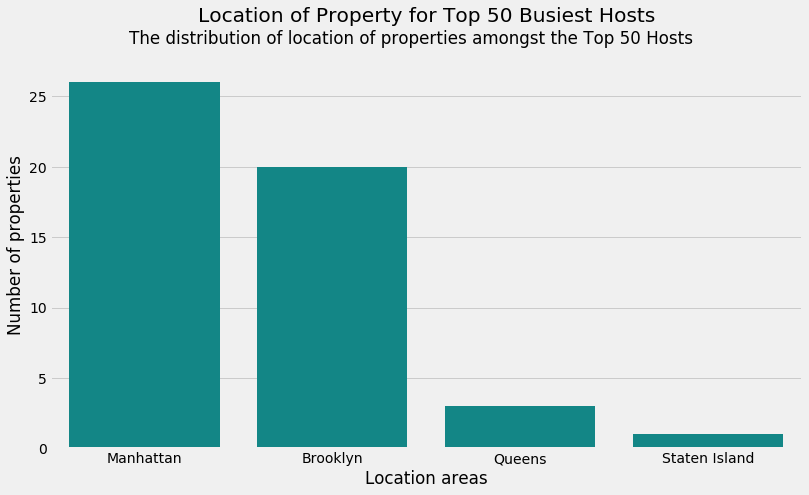

In [42]:
# percentages = Top_50.neighbourhood_group.value_counts(normalize=True) * 100

plt.figure(figsize=(12,7))
plt.style.use('fivethirtyeight')
sns.countplot(Top_50.neighbourhood_group,color='#009999',)
plt.title('Location of Property for Top 50 Busiest Hosts',y=1.03)
plt.suptitle('The distribution of location of properties amongst the Top 50 Hosts ',y=0.9)
plt.ylim(0,29)
plt.xlabel('Location areas')
plt.ylabel('Number of properties')
plt.show()

As concluded above from the frequency table, the Top 50 Hosts have their assets mainly in 'Manhattan' and 'Brooklyn'. The plot highlights these differences clearly. The findings here conclude that, the top 50 hosts are the busiest since majority of their properties are situated in either locations.<br>

This analysis leads to the next question - What areas have more traffic than others and why is that the case?<br>
From above conclusions, it was true that location is a factor controlling busyness of a property. The next step is to confirm this suspision on the entire dataset.
The sample under consideration is the `df_occupancy` created previosuly. This sample contains all hosts, their average occupancy rates/percentages and major locations of their properties.<br>

In terms of location, there are two levels for this analysis. One is the more general `neighbourhood_group` and the other on a granular level `neighbourhood`. Starting on level 1 the general location i.e. `neighbourhood_group`, first step is to analyze the general category of locations the properties reside in.

In [38]:
df.neighbourhood_group.value_counts()

Manhattan        12973
Brooklyn         11741
Queens            4205
Bronx              903
Staten Island      327
Name: neighbourhood_group, dtype: int64

Now grouping the sample by `neighbourhood_group` and taking a mean of `occupancy_percentage` to get a distribution of the occupancy across the neighbourhood groups.

In [43]:
grouped = df[['occupancy_percentage','neighbourhood_group']].groupby('neighbourhood_group')
df_location_group = grouped.mean().reset_index()
df_location_group

neighbourhood_group  occupancy_percentage
0               Bronx             11.564702
1            Brooklyn             12.936302
2           Manhattan             12.943789
3              Queens             12.622992
4       Staten Island             12.475958

The differences between the locations is seems very little and impossible to differentiate via the table. To make the differences clear, a bar plot below is made.

Text(0.5, 1.0, 'Percentage of occupancy vs Location')

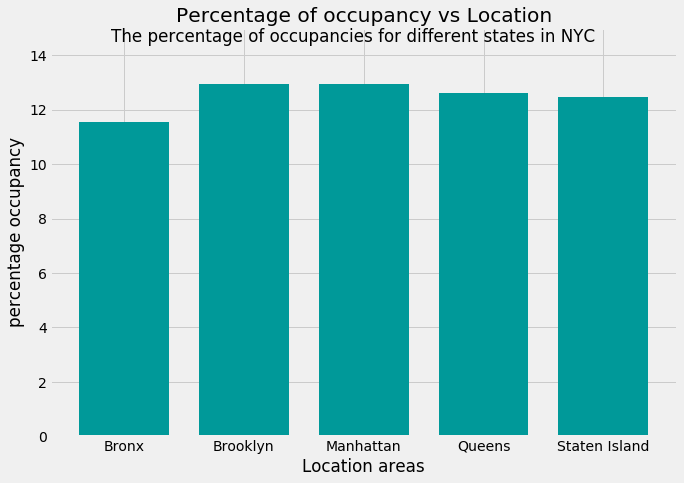

In [49]:
plt.figure(figsize=(10,7))
plt.style.use('fivethirtyeight')
plt.bar(df_location_group.neighbourhood_group,df_location_group.occupancy_percentage,color='#009999',width=0.75)
plt.ylim(0,15)
plt.xlabel('Location areas')
plt.ylabel('percentage occupancy')
plt.suptitle('The percentage of occupancies for different states in NYC',y=0.88)
plt.title('Percentage of occupancy vs Location')

The plot above shows that among the location areas, the areas having more traffic than others are - 'Manhattan', 'Brooklyn' and 'Queens' in close third. Though the differnces are narrow it is still significant.<br>
Combining the results of this plot and the previous plot,the conclusion can be, Hosts having properties in the areas, 'Manhatten', 'Brooklyn' and 'Queens' are busier than the rest in general.

For these 3 locations, the analysis can proceed onto granular information to find more specific locations in these 3 areas that recieve more traffic than the rest of the locations.

In [45]:
df.neighbourhood.value_counts()

Bedford-Stuyvesant    2369
Williamsburg          1957
Harlem                1645
Hell's Kitchen        1404
Bushwick              1388
                      ... 
Richmondtown             1
Silver Lake              1
Fort Wadsworth           1
Willowbrook              1
Rossville                1
Name: neighbourhood, Length: 218, dtype: int64

Similar to the problem we faced with `neighbourhood_group`, we will have to clean this column.

The samples are grouped by `neighbourhood` and aggregated on the `occupancy_percentage` by mean, similar to  `neightbourhood_group`.

In [46]:
grouped = df[['occupancy_percentage','neighbourhood']].groupby('neighbourhood')
df_location = grouped.mean().reset_index().sort_values(by='occupancy_percentage',ascending=False)
df_location

neighbourhood  occupancy_percentage
1     Arden Heights             36.767123
139    New Brighton             35.020274
163    Richmondtown             25.249315
101     Hunts Point             22.025342
168        Rosebank             21.797260
..              ...                   ...
64      Eastchester              1.894204
41       Co-op City              1.660274
115     Little Neck              0.841644
20     Breezy Point              0.482192
81   Fort Wadsworth              0.000000

[218 rows x 2 columns]

In [47]:
Top_10 = df_location.head(10)
Top_10

neighbourhood  occupancy_percentage
1    Arden Heights             36.767123
139   New Brighton             35.020274
163   Richmondtown             25.249315
101    Hunts Point             22.025342
168       Rosebank             21.797260
9       Baychester             21.249315
175    Silver Lake             20.975342
106  Jamaica Hills             20.043836
100       Huguenot             19.452055
196    Two Bridges             19.112562

The Top 10 locations that recieve maximum traffic. To visualize the differences better and see the direction of differences, the results are plotted as such.

Text(0, 0.5, 'locations')

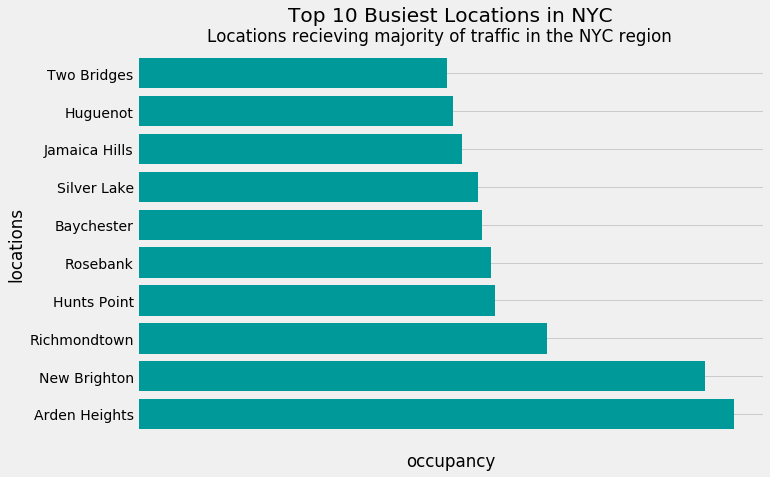

In [50]:
plt.figure(figsize=(10,7))
plt.style.use('fivethirtyeight')
plt.barh(y=Top_10.neighbourhood,width=Top_10.occupancy_percentage,color='#009999')
plt.title('Top 10 Busiest Locations in NYC',y=1.03)
plt.suptitle('Locations recieving majority of traffic in the NYC region',y=0.905)
plt.xlabel('occupancy')
plt.xticks([])
plt.ylabel('locations')

The graph above shows the Top 10 locations with occupancy comparisions.

An important thing to note here is that, the `occupancy percentage` in the bar plots above arent relative to eachother. They are average percentages of all occupancy percentages for that label. In short for each label occupancy percentages is the summary statistic - mean.

The final analysis is - Are there any relationships between prices and number of reviews for a given listing?<br>

The `price` column gives the price for a listing for the `minimum_nights` i.e. the price mentioned is for the minimum nights the customer has to book the listing for. Hence to even out the scale for the `price` column due to different `minimum_nights` criterion for each listing,the price is divided by minimum nights required to stay, to derive `price_per_day`.

In [51]:
df['price_per_day'] = df.price / df.minimum_nights

Both the concerned columns `price_per_day` and `number_of_reviews` are measured on an `interval/ratio` scale. So as to understand the distribution of these variables, histograms are plotted below.

(0, 400)

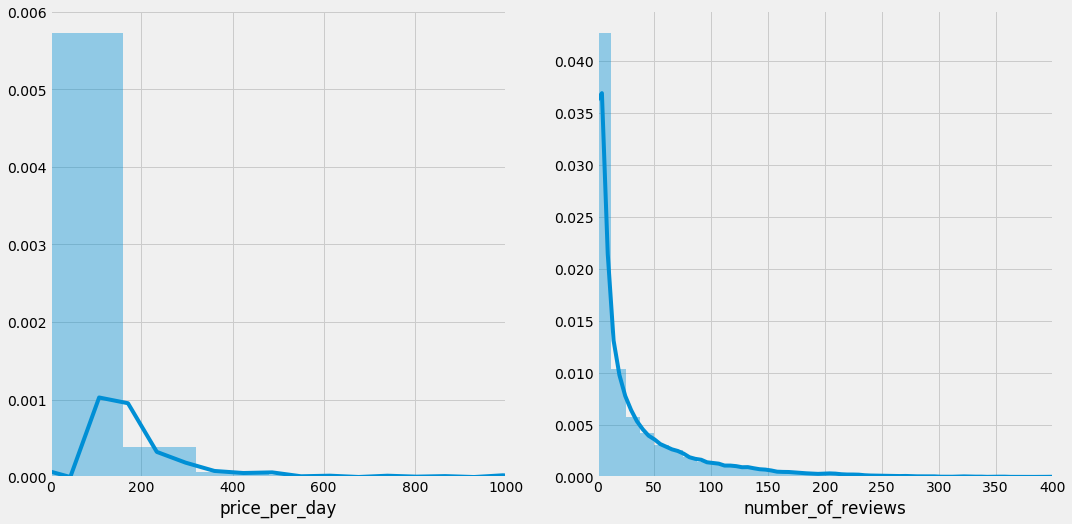

In [53]:
plt.subplots(figsize=(16,8))
plt.subplot(1,2,1)
sns.distplot(df.price_per_day,kde=True)
plt.xlim([0,1000])
plt.subplot(1,2,2)
sns.distplot(df.number_of_reviews,kde=True)
plt.xlim([0,400])

Both the plots are heavily right skewed, and the distribution plot (histogram) gives no information as to the relationship between the two. To gain a sense of relationship between the two, a scatter plot is generated below.

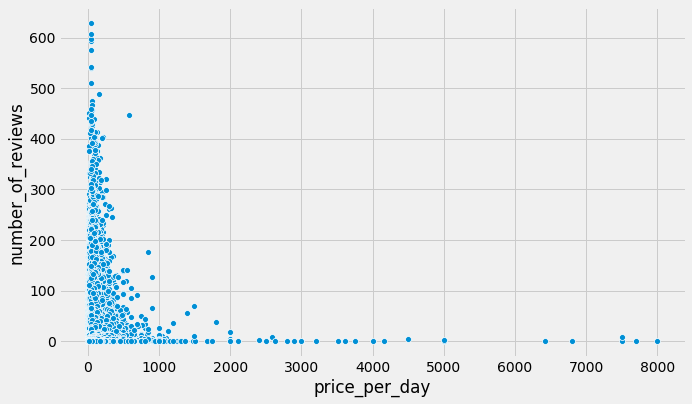

In [54]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df.price_per_day,y=df.number_of_reviews)

The two plots above, `Histograms` and the `scatter plot`, hardly give any information pertaining to the analysis.<br>
Since both columns are on the `interval scale` and show no direct relationship between the two. A proxy to finding relationship would be to bin one of the varibles to `ordinal scale`, hence make it comparable with respect to the other variable. Looking into the price variable for this need,

In [55]:
df.price_per_day.describe()

count    30149.000000
mean        73.055984
std        169.476160
min          0.000000
25%         20.000000
50%         45.000000
75%         85.000000
max       8000.000000
Name: price_per_day, dtype: float64

The `price_per_day` variable has a relatively smaller mean as comapared to the extent the value go up to. A closer look at the distribution for the `price_per_day` variable where the price is below 500 dollars.

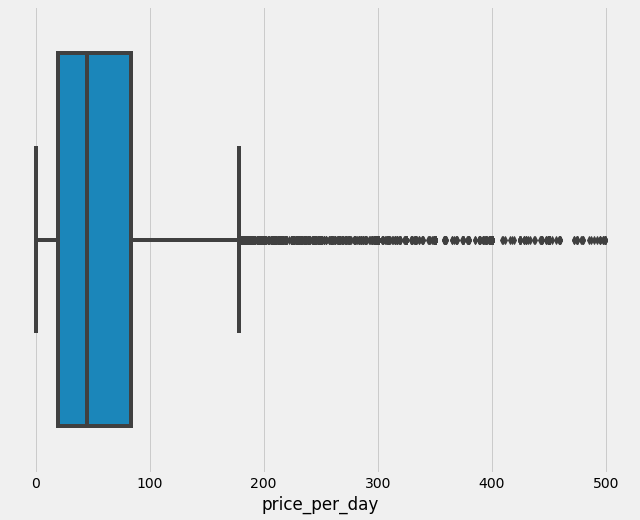

In [56]:
plt.figure(figsize=(10,8))
sns.boxplot(df[df.price_per_day < 500].price_per_day)

The majority of listings are at a lower price point lesser than 200 dollars. This makes the bining/segmentation of the `price_per_day` variable unequal. Choosing the bins is crucial and has to really reflect that data.

The `price_per_day` variable is segmented into 5 segments :-

    1. Very cheap - 15 dollars or lesser
    2. Cheap - 20 to 65 dollars
    3. Budget - 65 to 120 dollars
    4. Expensive - 120 to 200 dollars
    5. Very Expensive - 200 dollars or greater
    
The price points of 0 dollars and per day price points greater than 1000 dollars,are extreme values in the assumption and segmentation made. These values can skew the findings. Since the purpose is to find a trend/relationship between price points of listings and the number of reviews the listings recieve, The above assumption that these are extremes and do not contribute in deciding the trend majorly seems like a good enough proxy.

In [57]:
df = df[~((df.price_per_day == 0) | (df.price_per_day > 1000))]

In [63]:
def label(data):
    if data <= 25:
        return 'Very cheap'
    elif data > 25 and data <= 65:
        return 'Cheap'
    elif data > 65 and data <= 120:
        return 'Budget'
    elif data > 120 and data <= 200:
        return 'Expensive'
    else:
        return 'Very expensive'

df['price_per_day_labels'] = df.price_per_day.apply(label)
df.price_per_day_labels.value_counts(dropna=False).iloc[[1,0,2,3,4]]

Very cheap         9348
Cheap             10350
Budget             6235
Expensive          2709
Very expensive     1435
Name: price_per_day_labels, dtype: int64

The columns can now be compared. The labels of the `price_per_day_labels` columns will be compared against each other with respect to the `number_of_reviews` column. The grouping is done on the `price_per_day_labels` and aggregated on `number_of_reviews` via `sum`.

In [81]:
grouped = df[['price_per_day_labels','number_of_reviews','occupancy_percentage']].groupby('price_per_day_labels')
df_price_range = grouped.agg({
    'number_of_reviews':'sum',
    'occupancy_percentage':'mean'
}).reset_index()
df_price_range

price_per_day_labels  number_of_reviews  occupancy_percentage
0               Budget             256969             11.085010
1                Cheap             427814             13.167304
2            Expensive              92211              9.288539
3           Very cheap             152961             15.756171
4       Very expensive              32915              6.518616

The differences between the price points in terms of number of reviews are very clear.To make the direction and size of difference clearer a visualization is made below. For visualization purposes, the absolute sums of `number_of_reviews` is converted to percentages.

In [82]:
total_reviews = sum(df_price_range.number_of_reviews)
df_price_range['reviews_percentage'] = df_price_range.number_of_reviews / total_reviews * 100
df_price_range = df_price_range.iloc[[3,1,0,2,4]]
df_price_range

price_per_day_labels  number_of_reviews  occupancy_percentage  \
3           Very cheap             152961             15.756171   
1                Cheap             427814             13.167304   
0               Budget             256969             11.085010   
2            Expensive              92211              9.288539   
4       Very expensive              32915              6.518616   

   reviews_percentage  
3           15.885945  
1           44.431128  
0           26.687819  
2            9.576682  
4            3.418426

Text(0.5, 0, 'Price points')

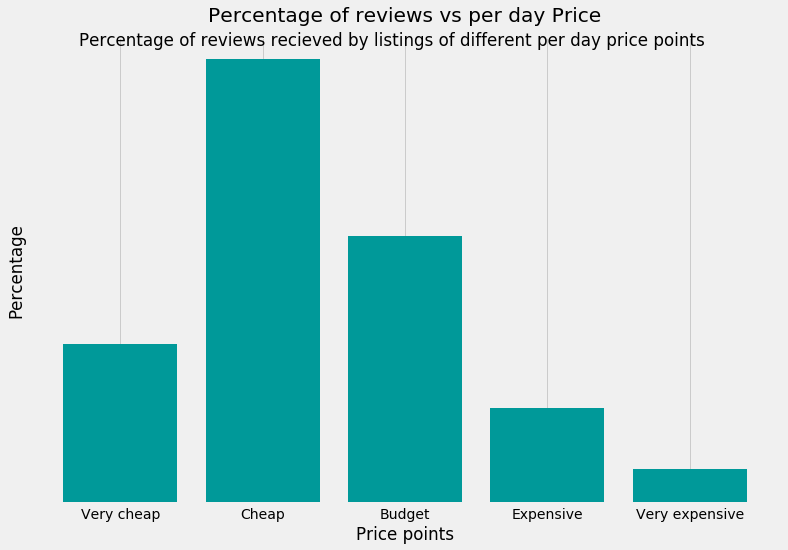

In [83]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')
plt.bar(x=df_price_range.price_per_day_labels, height=df_price_range.reviews_percentage,color='#009999')
plt.title('Percentage of reviews vs per day Price',y=1.02)
plt.suptitle('Percentage of reviews recieved by listings of different per day price points',y=0.89)
plt.yticks([])
plt.ylabel('Percentage')
plt.xlabel('Price points')

From the plot above the conclusion can be drawn that listings that quote a per-day-price point between 20 to 120 dollars get maximum number of reviews. These properties are considered to be fair in terms of price.<br>

Taking it a step further, analyzing occupancy rates for each price point label,

Text(0.5, 0, 'Price points')

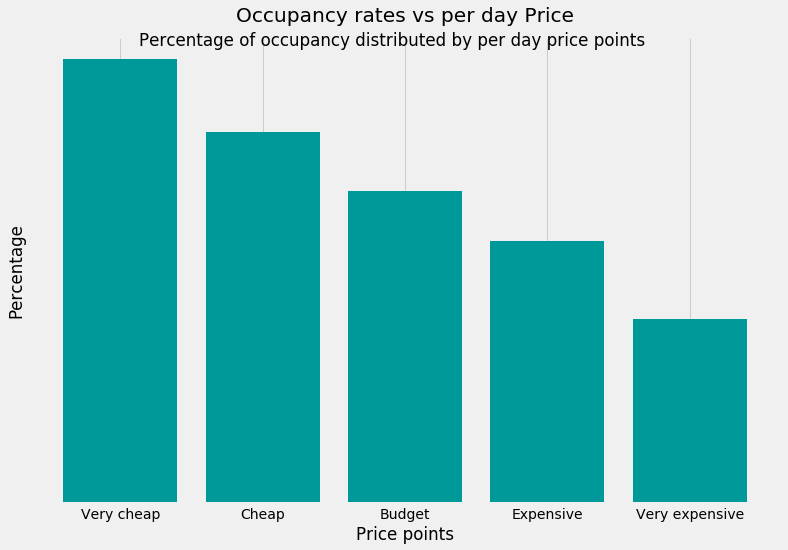

In [80]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')
plt.bar(x=df_price_range.price_per_day_labels, height=df_price_range.occupancy_percentage,color='#009999')
plt.title('Occupancy rates vs per day Price',y=1.02)
plt.suptitle('Percentage of occupancy distributed by per day price points',y=0.89)
plt.yticks([])
plt.ylabel('Percentage')
plt.xlabel('Price points')

The conclusion from the two plots above:- 
* The Cheap and budget price points i.e. 20 to 120 dollars recieve more reviews than the rest.
* The same is not true for occupancy rates. The very cheap price points i.e 15 dollars or lesser have more occupancy rates through one period of business.

In [88]:
Top_10.neighbourhood

1      Arden Heights
139     New Brighton
163     Richmondtown
101      Hunts Point
168         Rosebank
9         Baychester
175      Silver Lake
106    Jamaica Hills
100         Huguenot
196      Two Bridges
Name: neighbourhood, dtype: object

In conclusion, the following observations were made from the analysis:- 

    1. The Top 50 hosts, that have high occupancy percentages(busiest)
    * Zoey             * Daniel             * Jordi               * Amanda
    * Sara             * Harry              * Dipti               * Poma
    * Moncef           * Danielle           * A-B                 * Martin & Steve
    * Steven           * Zach               * Lee                 * Vangelis
    * Viberlyn         * Eleni              * Emma                * Emily Wes
    * Sara             * Safia              * Nour                * Sara
    * Jean-Yves        * Nick               * Gianni              * Jk
    * Jean             * Brie               * Vitaly And Lena     * Josie
    * LuLu             * Curtiss            * Florence            * Rosa
    * Tokunbo          * Yu                 * Pete                * Michelle
    * Robert           * William            * Jack                * Amit
    * Joshua           * Stephanie          * Nicolas             * Kim
    * Vlad             * Joanna
    The properties of these Top 50 hosts are mainly situated in - Manhattan and Brooklyn.
    
    2. The Top location groups that recieve the maximum traffic are 
    * Manhattan 
    * Brooklyn
    As concluded from the Top 50 busiest hosts as well as the entire population. 
    Accessing more granular information the Top 10 busiest neighbourhoods are
    * Arden Heights      * New Brighton       * Richmondtown
    * Hunts Point        * Rosebank           * Baychester
    * Silver Lake        * Jamaica Hills      * Huguenot
    * Two Bridges
    
    3. Listings priced about 20 dollars to 120 dollars on per day basis, recieve more number 
    of reviews than other price points. Whereas listings priced 15 dollars or less are busier than the rest.

